 <div style="text-align:center;">
  <span style="color:green; font-size:2em; font-weight:bold;">Modélisation</span><br><br>

# <span style="color:green">Introduction</span><br><br> 

### <span style="color:green">Références et équations de base de la relation d'Okun</span><br><br> 

Dans cette partie, nous allons proposer une modélisation permettant de vérifier empiriquement la loi d'Okun, à partir des bases de données établies dans la partie "Préparation_données.ipynb".

La loi d'Okun, indique que : "chaque fois que le PIB chute d'un certain pourcentage, par rapport au produit potentiel, le taux de chômage augmente d'environ un point de pourcentage. Ainsi, lorsque le PIB réel diminue, le taux de chômage augmente." (Mankiw, 2003)

Pour cette modélisation, on s'inspire des travaux suivants : 

- [1]. Traoré, D. L., Diakite, S., & Mariko, O. (2021). Croissance et chômage au Mali : Vérification empirique de la loi d'Okun. Revue Malienne de Science et de Technologie, Série C : Sciences Humaines et Sociales, 02(25), Page. ISSN 1987-1031. CNRST, Bamako, Mali.

- [2]. Aassif, Z. L'extraction de la tendance cycle. Haut-Commissariat au Plan, Direction de la comptabilité nationale. 

- [3]. Belaidi, N. (2022, 28 mars). Validation croisée en Machine Learning. Consulté le  12 décembre 2023. URL : https://blent.ai/blog/a/validation-croisee-machine-learning.


Le travail [1] nous présente deux équations de base de la relation d'Okun, la version en "différences premières" et la "version gap".

- Version en "différences premières" : 
$$\Delta u = C + \beta\Delta \text{pib} + \epsilon$$

- "Version gap" : 
$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

avec $u$ le taux de chômage, $u^*$ le taux de chômage naturel, $\text{pib}^*$ le PIB potentiel et c, $\beta$ et $\epsilon$  des constantes à déterminer grâce à la modélisation. 

### <span style="color:green">Equation et outils utilisés dans notre modélisation</span><br><br> 

Pour la modélisation, nous allons utiliser la version "gap", qui relie le taux de chômage et le PIB de la manière suivante : 

$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

Pour extraire la tendance à long terme du taux de chômage et du PIB (c'est-à-dire, le taux de chômage naturel et le PIB potentiel), à partir de la base de données, nous allons utiliser le filtre de Hodrick-Prescott. Ce filtre est introduit dans [2], et permet de décomposer une série selon sa tendance à long terme et son cycle (fluctuations autour de la tendance) à plus court terme.

Par ailleurs, pour prendre en compte la dynamique temporelle de nos données, nous allons utiliser le modèle ARDL (Auto Regressive Distributed Lag), introduit dans [2].

### <span style="color:green">Les différentes étapes de notre modélisation</span><br><br> 


Pour effectuer notre modélisation sur les données obtenues suite au traitement, nous allons tout d'abord regrouper les pays présents selon différents critères, grâce à la technique du clustering. 
Nous sélectionnerons un pays de manière aléatoire au sein de chaque groupe afin de vérifier la loi d'Okun (ou alors nous vérifierons la loi d'Okun pour chaque groupe après agrégation).

(Par ailleurs, nous allons utiliser une méthode de validation croisée afin de valider notre modèle. Nous allons tout d'abord établir les paramètres du modèle grâce au jeu d'entrainement reprenant les données de 1994 à 2016 ; puis nous vérifierons la précision du modèle grâce au jeu de test reprenant les données de 2017 à 2023.)


# <span style="color:green"> I- Extraction de la tendance à long terme du taux de chômage et du PIB</span><br><br> 

## <span style="color:green"> Importation des bases de données</span><br><br> 

In [12]:
import declarations as d 

In [47]:
# Base de données obtenue suite au nettoyage
data = d.pd.read_csv('bases/final_data.csv', encoding='latin-1')
data.head(2)

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694


### <span style="color:green"> Base de données pour la modélisation des séries temporelles </span><br><br> 

Pour la modélisation des séries temporelles modélisant la relation entre le PIB et le taux de chômage, nous avons besoin de ces variables pour chaque pays en colonnes et de la date en indice. 

In [116]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_pivot = data.pivot(index=['YEAR'], columns='COUNTRY',
                    values=['Unemployment_rate', 'GDP_rate'])

# Ajuster les noms de colonnes
df_pivot.columns = [f'{col[1]}_{col[0].lower()}' for col in df_pivot.columns]

# Réinitialiser l'index pour avoir les colonnes YEAR et MONTH comme des colonnes régulières
df_pivot.reset_index(inplace=True)

# Afficher le nouveau dataframe
df_pivot.head(2)


,YEAR,AUS_unemployment_rate,AUT_unemployment_rate,BEL_unemployment_rate,BGR_unemployment_rate,CAN_unemployment_rate,CHE_unemployment_rate,CZE_unemployment_rate,DEU_unemployment_rate,ESP_unemployment_rate,...,POL_gdp_rate,PRT_gdp_rate,ROU_gdp_rate,RUS_gdp_rate,SGP_gdp_rate,SVK_gdp_rate,SVN_gdp_rate,SWE_gdp_rate,URY_gdp_rate,USA_gdp_rate
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


In [117]:
df_pivot = df_pivot.rename(columns=lambda x: x.replace('_rate', ''))
df_pivot.head(2)

,YEAR,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


### <span style="color:green"> Base de données pour le clustering </span><br><br> 

Pour le clustering, nous avons besoin d'une base de données avec en indice le nom des pays et en colonnes, les différents critères considérés, moyennés sur la période considérée.

In [88]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_cluster = data.pivot_table(index='COUNTRY', values=['Unemployment_rate', 'GDP_rate','life_expentancy',
       'pop_growth_rate'], aggfunc='mean')

df_cluster.head(2)

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969


In [101]:
# Afficher les groupes et les pays
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    print(f'Cluster {cluster_num + 1}: {list(countries_in_cluster)}')

Cluster 1: ['ESP', 'FIN', 'POL', 'PRT', 'SVK', 'SVN']
Cluster 2: ['ROU']
Cluster 3: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CZE', 'DEU', 'FRA', 'GBR', 'IRL', 'JPN', 'LUX', 'NOR', 'NZL', 'PHL', 'SGP', 'SWE', 'USA']
Cluster 4: ['BGR', 'EST', 'LTU', 'RUS']


## <span style="color:green">Extraction de la tendance à long terme pour le taux de chômage (unemployement)</span><br><br> 

In [69]:
# Extraire toutes les colonnes avec le suffixe "_rate" ainsi que la colonne des dates
columns_unemployment = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_unemployment')] 
df_unemployment = df_pivot[columns_unemployment]
df_unemployment.set_index('YEAR', inplace = True)

df_unemployment.head(2)

,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,EST_unemployment,...,POL_unemployment,PRT_unemployment,ROU_unemployment,RUS_unemployment,SGP_unemployment,SVK_unemployment,SVN_unemployment,SWE_unemployment,URY_unemployment,USA_unemployment
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,7.600000,...,16.450000,7.756329,10.9,6.759498,1.750000,14.620000,14.650000,10.839335,12.100000,6.2
1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,7.466667,...,16.533333,7.916827,10.9,6.574419,1.666667,14.426667,14.966667,10.866990,12.083333,6.5


## <span style="color:green">Extraction de la tendance à long terme pour le PIB (gdp)</span><br><br> 

In [71]:
# Extraire toutes les colonnes avec le suffixe "_gdp" ainsi que la colonne des dates
columns_gdp = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_gdp')] 
df_gdp = df_pivot[columns_gdp]
df_gdp.set_index('YEAR', inplace = True)

df_gdp.head(2)

,AUS_gdp,AUT_gdp,BEL_gdp,BGR_gdp,CAN_gdp,CHE_gdp,CZE_gdp,DEU_gdp,ESP_gdp,EST_gdp,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,0.501645,0.779464,0.796550,0.559233,0.680429,0.907331,0.814153,0.794548,0.774291,0.525902,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1994-02,0.502208,0.783616,0.798246,0.559740,0.680180,0.909250,0.818056,0.796374,0.778426,0.534253,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


# II- Clustering : regroupement des pays selon des critères de développement

Dans cette partie, on va utiliser la méthode du clustering pour regrouper les pays de la base de données selon 4 critères : 
- le PIB,
- le taux de chômage, 
- la durée de vie,
- et le taux de croissance de la population. 
chaque variable moyennée sur la période considérée. 


In [115]:
# on supprime d'abord les lignes ayant des valeurs manquantes
df_cluster.dropna(inplace=True)
df_cluster.head()

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate,Cluster
COUNTRY,,,,,
AUS,0.761392,6.027355,80.916318,1.342107,2
AUT,0.899732,7.236287,79.720527,0.449969,2
BEL,0.913237,7.774560,79.483950,0.498965,2
BGR,0.799515,10.575434,72.878191,-0.792854,3
CAN,0.922738,7.485185,80.470733,1.032642,2


In [105]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


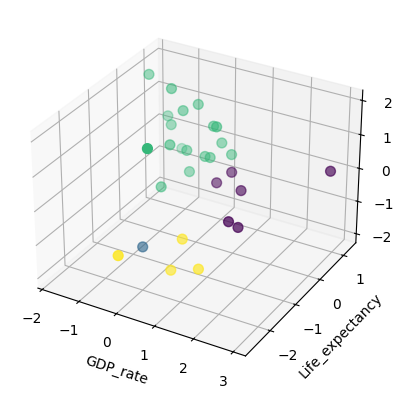

In [113]:
# Standardiser les données (important pour K-means)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Appliquer l'algorithme K-means
num_clusters = 4  # Choisissez le nombre de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualisation en 3D (utilisant les variables GDP_rate, Life_expectance, Pop_growth_rate)
fig = d.plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:, 1], df_scaled[:, 2], df_scaled[:, 3], c=df_cluster['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('GDP_rate')
ax.set_ylabel('Life_expectancy')
ax.set_zlabel('Pop_growth_rate')
d.plt.show()

In [114]:
# Afficher les groupes et les pays
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    print(f'Cluster {cluster_num + 1}: {list(countries_in_cluster)}')

Cluster 1: ['ESP', 'FIN', 'POL', 'PRT', 'SVK', 'SVN']
Cluster 2: ['ROU']
Cluster 3: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CZE', 'DEU', 'FRA', 'GBR', 'IRL', 'JPN', 'LUX', 'NOR', 'NZL', 'PHL', 'SGP', 'SWE', 'USA']
Cluster 4: ['BGR', 'EST', 'LTU', 'RUS']


# III- Vérification de la loi pour un pays tiré de manière i.i.d. dans chaque groupe


## Modélisation de la relation entre PIB et taux de chômage, pour un pays donné, grâce au modèle ARDL 

### Extraction de la tendance à long terme du PIB et du taux de chômage d'un pays.

Dans cette partie, on définit une classe qui permet de tracer la tendance à long terme et les cycles à court terme de ces deux mêmes variables. 

La méthode df_gap() de cette classe permet d'obtenir une série avec les valeurs de la différence entre la valeur réelle et la tendance à long terme pour un pays considéré. 

In [144]:
class CountryData:
    def __init__(self, country_code, unemployment_data, gdp_data):
        """
        Initialize a CountryData instance.

        Parameters:
        - country_code (str): The country code.
        - unemployment_data (pd.Series): Time series data for unemployment rate.
        - gdp_data (pd.Series): Time series data for GDP rate.
        """
        
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']

    def plot_trend_cycle(self):
        """
        Plot the trend and cycle components for unemployment rate and GDP rate after applying the Hodrick-Prescott filter to the time series.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)

        # Plot the trend and cycle of unemployment rate
        d.plt.plot(x, label='Original series')
        d.plt.plot(trend_x, label='Trend')
        d.plt.plot(cycle_x, label='Cycle')
        d.plt.legend()
        d.plt.show()

        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)

        # Plot the trend and cycle of the trend
        d.plt.plot(y, label='Originale series')
        d.plt.plot(trend_y, label='Trend')
        d.plt.plot(cycle_y, label='Cycle')
        d.plt.legend()
        d.plt.show()
        
    def df_gap(self):
        """
        Calculate the gap series for unemployment rate and GDP rate.

        Returns:
        - df_gap (pd.DataFrame): DataFrame containing the gap values.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)
    
        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)
    
        # Calculate the new series by removing the trend
        gap_unemployment = x - trend_x
        gap_gdp = y - trend_y

        # Create a DataFrame with the new series
        df_x = d.pd.DataFrame({'YEAR': x.index, 'gap rates': gap_unemployment.values})
        df_y = d.pd.DataFrame({'YEAR': y.index, 'gap gdp': gap_gdp.values})

        # Merge the DataFrames on the 'YEAR' column
        df_gap = d.pd.merge(df_x, df_y, on='YEAR', how='inner')

        return df_gap


### Modèle ARDL

## Tirage d'un pays de manière aléatoire dans chaque cluster et application du modèle

In [ ]:
belgium = CountryData('BEL', df_unemployment, df_gdp)
result_data_belgium = belgium.plot_trend_cycle()
belgium.df_gap()

 ## <span style="color:green">Exemple de la Belgique</span><br><br> 

### <span style="color:darkred">Régression linéaire simple avec la méthode OLS (Ordinary Least Squares)</span><br><br> 

La régression linéaire simple considère chaque observation comme indépendante des autres, ce qui signifie qu'elle ne modélise pas l'autocorrélation ou la dépendance temporelle potentielle entre les observations successives. 

In [ ]:
# S'assurer que la colonne Dates est au format datetime
data_Belgique['Dates'] = d.pd.to_datetime(data_Belgique['Dates'])

# Ajouter une constante à vos données pour inclure l'intercept dans le modèle
data_Belgique['const'] = 1

# Spécifier les variables indépendantes (X) et dépendante (y)
X = data_Belgique[['const', 'rates']]
y = data_Belgique['gdp']

# Créer et ajuster le modèle de régression linéaire
model = d.sm.OLS(y, X)
results = model.fit()

# Afficher les résultats du modèle
print(results.summary())


### <span style="color:darkred">Modèle ARIMA (AutoRegressive Integrated Moving Average)</span><br><br> 

Ici, on considère un modèle de séries temporelles, qui capture la dépendance temporelle et modélise la dynamique temporelle des données.

In [ ]:
# AACF (AutoCorrelation Function)
# PACF (Partial AutoCorrelation Function)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Tracez l'ACF et PACF
fig, ax = d.plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_Belgique['gdp'], lags=20, ax=ax[0])
plot_pacf(data_Belgique['gdp'], lags=20, ax=ax[1])
d.plt.show()

In [ ]:
# Créer et ajuster le modèle ARIMA
model = d.sm.tsa.ARIMA(data_Belgique['gdp'], order=(2, 2, 11))  # Spécifier l'ordre du modèle ARIMA
results = model.fit()

# Afficher les résultats du modèle
print(results.summary())


### <span style="color:darkred">Modèle ARDL</span><br><br> 

In [ ]:
# Spécifiez les paramètres du modèle ARDL
endog_variable = data_Belgique['gdp']
lags_endog = 2  # Nombre de retards pour la variable endogène
exog_variables = data_Belgique['rates']
lags_exog = [1, 2]  # Nombre de retards pour les variables exogènes
trend = 'c'  # 'c' pour une constante, 'ct' pour une constante et une tendance linéaire, ou None pour aucun

# Créez le modèle ARDL
model_ardl = d.sma.ARDL(endog_variable, lags=lags_endog, exog=exog_variables, order=lags_exog, trend=trend)

# Ajustez le modèle
results = model_ardl.fit()

# Affichez les résultats du modèle
print(results.summary())

In [ ]:
# Spécifiez les retards que vous souhaitez inclure
lags = 2

# Créez des colonnes de lags pour rates
for i in range(1, lags + 1):
    data_Belgique[f'rates_lag{i}'] = data_Belgique['rates'].shift(i)

# Spécifiez les variables indépendantes (X) et dépendante (y)
X = data_Belgique[['const', 'rates_lag1', 'rates_lag2']]
y = data_Belgique['gdp']

# Éliminez les lignes avec des valeurs manquantes introduites par les lags
data_Belgique = data_Belgique.dropna()

# Créez et ajustez le modèle de régression linéaire avec lags
model = d.sm.OLS(y, X)
results = model.fit()

# Affichez les résultats du modèle
print(results.summary())
